# Signal-to-noise ratio criterion for strong lens detectability

This notebook demonstrates how signal-to-noise ratio is calculated in `SLSim` and how it can be used to filter out low SNR strong lenses when drawing a population.

In [1]:
import corner
import matplotlib.pyplot as plt
import numpy as np
from astropy.cosmology import FlatLambdaCDM
from astropy.units import Quantity

import slsim.Pipelines as pipelines
import slsim.Sources as sources
import slsim.Deflectors as deflectors
from slsim.Lenses.lens_pop import LensPop
from slsim.ImageSimulation.image_simulation import simulate_image

## Set up a population of strong lenses

Here, we're simulating static, galaxy-galaxy strong lenses imaged by LSST.

In [2]:
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)
sky_area = Quantity(value=10, unit="deg2")
sky_area_galaxies = Quantity(value=0.5, unit="deg2")

kwargs_deflector_cut = {"band": "g", "band_max": 26, "z_min": 0.01, "z_max": 2.5}
kwargs_source_cut = {"band": "g", "band_max": 26, "z_min": 0.1, "z_max": 5.0}

galaxy_simulation_pipeline = pipelines.SkyPyPipeline(
    skypy_config=None, sky_area=sky_area_galaxies, filters=None, cosmo=cosmo
)
lens_galaxies = deflectors.AllLensGalaxies(
    red_galaxy_list=galaxy_simulation_pipeline.red_galaxies,
    blue_galaxy_list=galaxy_simulation_pipeline.blue_galaxies,
    kwargs_cut=kwargs_deflector_cut,
    kwargs_mass2light=None,
    cosmo=cosmo,
    sky_area=sky_area_galaxies,
)
source_galaxies = sources.Galaxies(
    galaxy_list=galaxy_simulation_pipeline.blue_galaxies,
    kwargs_cut=kwargs_source_cut,
    cosmo=cosmo,
    sky_area=sky_area_galaxies,
    catalog_type="skypy",
    extended_source_type="single_sersic",
)
gg_lens_pop = LensPop(
    deflector_population=lens_galaxies,
    source_population=source_galaxies,
    cosmo=cosmo,
    sky_area=sky_area,
)

/nfshome/bwedig/slsim/slsim/Deflectors/DeflectorPopulation/all_lens_galaxies.py:56: UserWarning: Angular size is converted to arcsec because provided input_catalog_type is skypy. If this is not correct, please refer to the documentation of the class you are using
  red_galaxy_list = catalog_with_angular_size_in_arcsec(
/nfshome/bwedig/slsim/slsim/Deflectors/DeflectorPopulation/all_lens_galaxies.py:59: UserWarning: Angular size is converted to arcsec because provided input_catalog_type is skypy. If this is not correct, please refer to the documentation of the class you are using
  blue_galaxy_list = catalog_with_angular_size_in_arcsec(


## Draw the population: apply cuts

Signal-to-noise ratio cuts for each band can be passed to the `kwargs_lens_cut` argument of the `draw_population()` method in the following way:

```python
snr_limit = {
    "g": 20,
    "r": 20,
}
kwargs_lens_cuts = {
    "snr_limit": snr_limit,
}

gg_lens_population = gg_lens_pop.draw_population(
    kwargs_lens_cuts=kwargs_lens_cuts
)
```

However, in the following block, we won't add this cut. Later in this notebook, we'll look at the full range of SNRs for this population to sanity check the SNRs being calculated.

In [3]:
# This block may take up to five minutes to execute

kwargs_lens_cuts = {
    "min_image_separation": 0.8,
}

gg_lens_population = gg_lens_pop.draw_population(kwargs_lens_cuts=kwargs_lens_cuts)

print("Number of lenses:", len(gg_lens_population))

Number of lenses: 360


## Corner plot

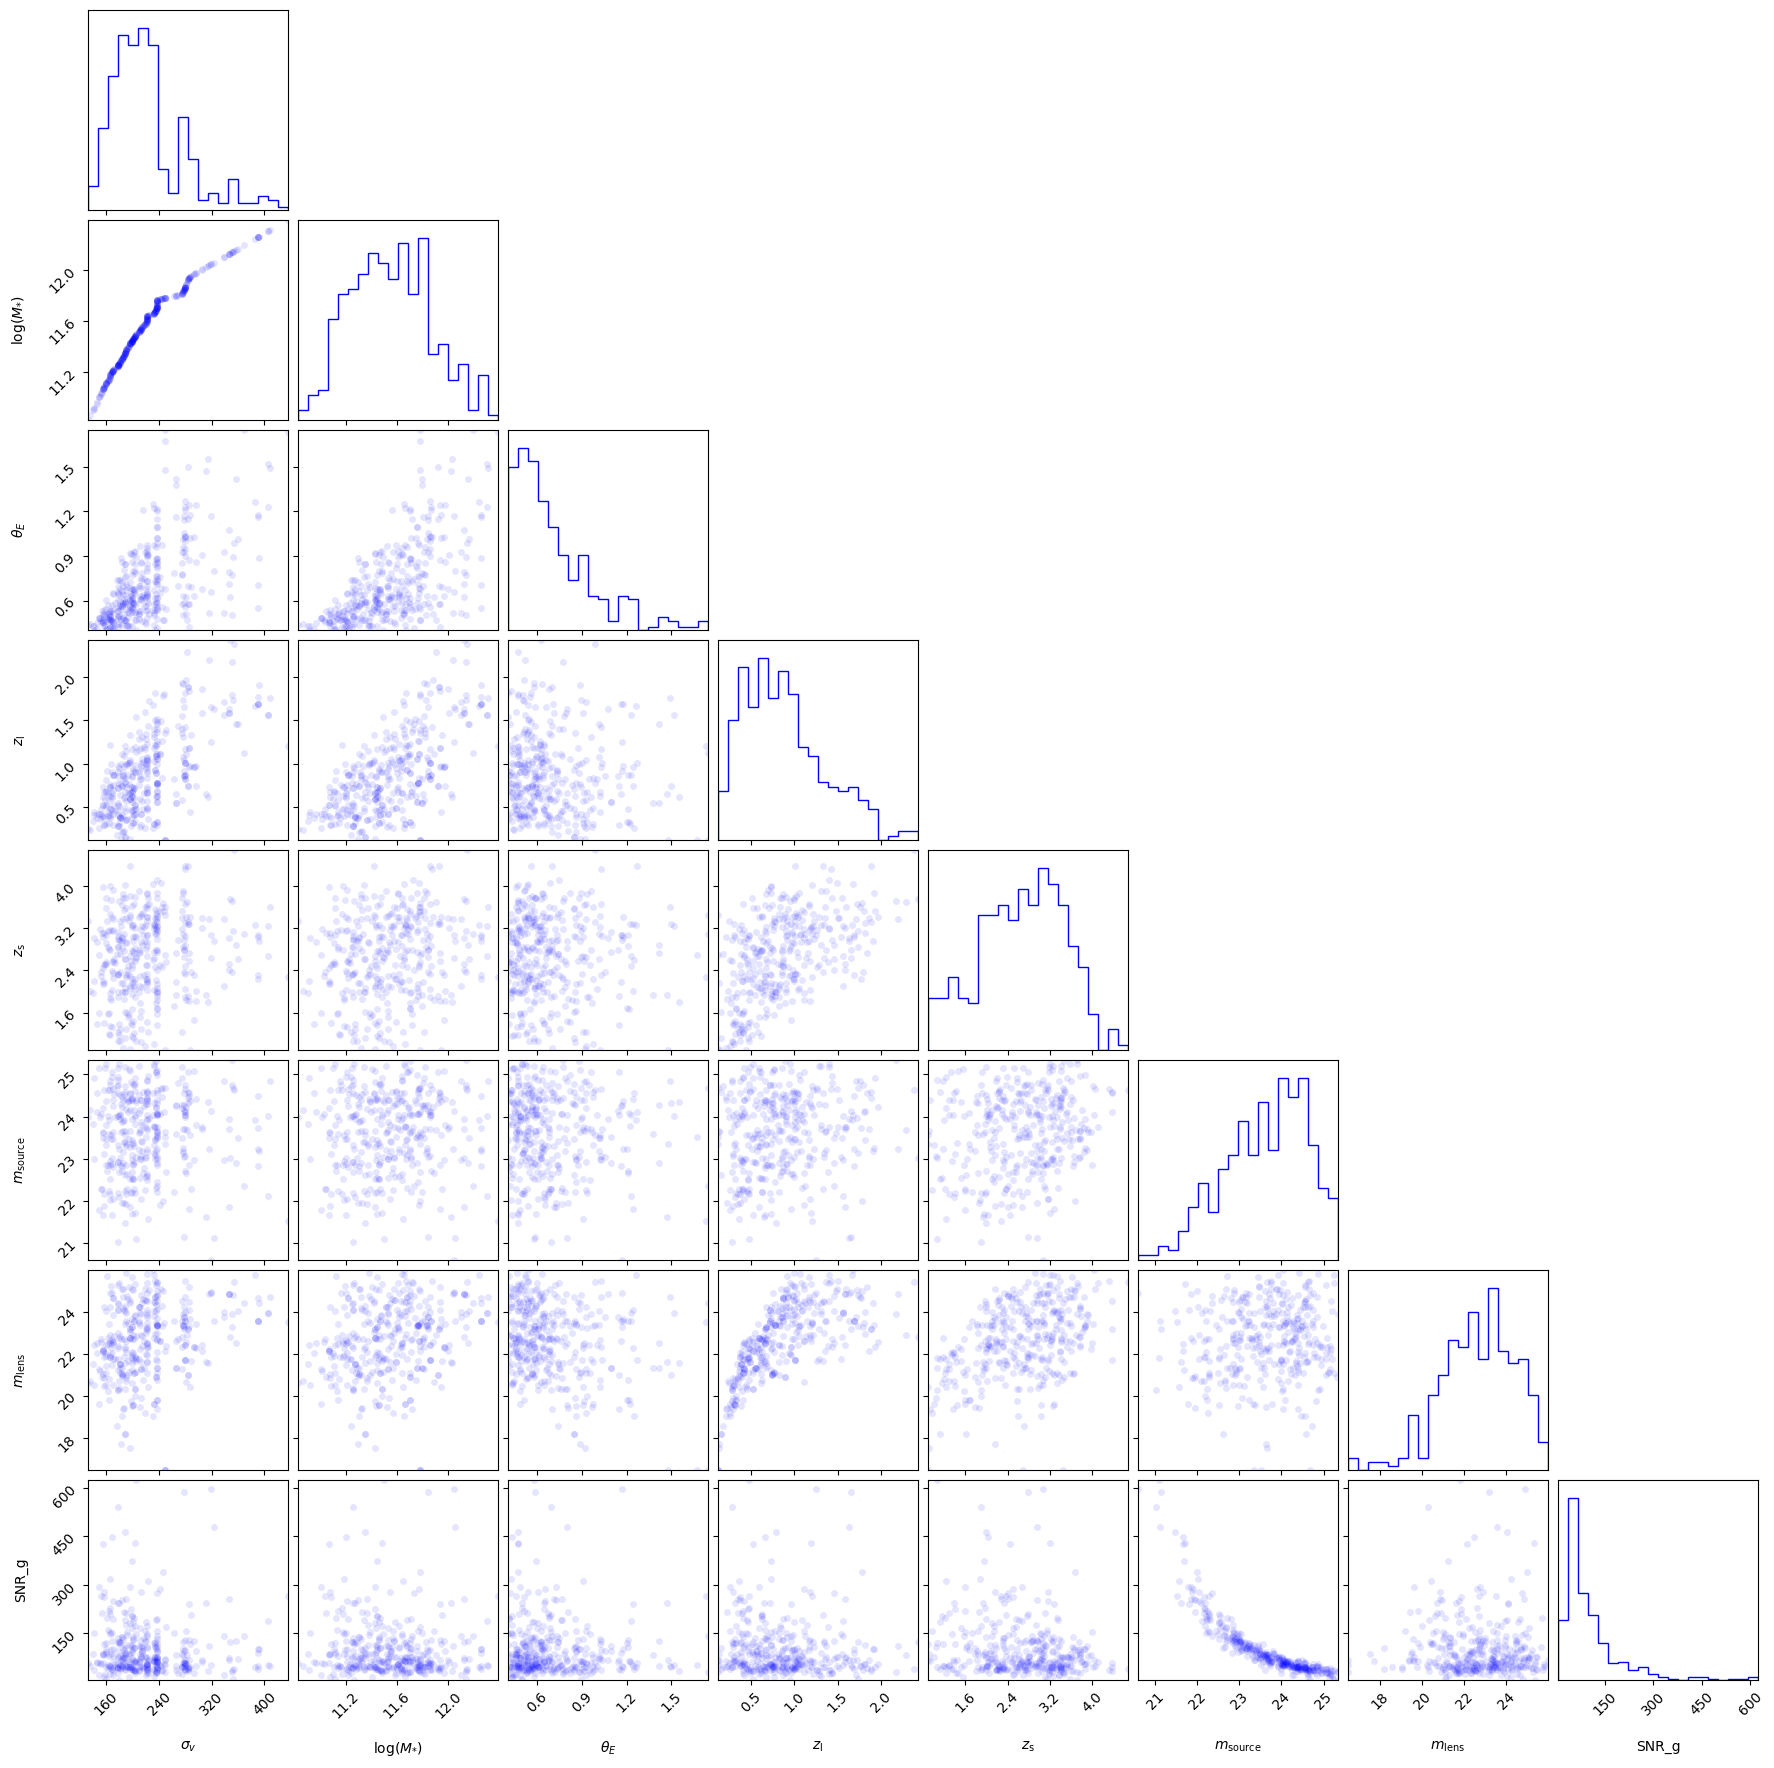

In [4]:
lens_samples = []
labels = [
    r"$\sigma_v$",
    r"$\log(M_{*})$",
    r"$\theta_E$",
    r"$z_{\rm l}$",
    r"$z_{\rm s}$",
    r"$m_{\rm source}$",
    r"$m_{\rm lens}$",
    "SNR_g",
]

for gg_lens in gg_lens_population:
    vel_disp = gg_lens.deflector_velocity_dispersion()
    m_star = gg_lens.deflector_stellar_mass()
    theta_e = gg_lens.einstein_radius[0]
    zl = gg_lens.deflector_redshift
    zs = gg_lens.source_redshift_list[0]
    source_mag = gg_lens.extended_source_magnitude(band="g", lensed=True)[0]
    deflector_mag = gg_lens.deflector_magnitude(band="g")
    snr = gg_lens.snr(
        band="g",
        fov_arcsec=np.max([theta_e * 4, 1]),  # 4 times Einstein radius, or at least 1"
        observatory="LSST",
        snr_per_pixel_threshold=1,
    )
    if snr is None:
        snr = 0  # snr() returns None if no pixels exceed per-pixel threshold
    lens_samples.append(
        [vel_disp, np.log10(m_star), theta_e, zl, zs, source_mag, deflector_mag, snr]
    )

hist2dkwargs = {
    "plot_density": False,
    "plot_contours": False,
    "plot_datapoints": True,
    "color": "b",
    "data_kwargs": {"ms": 5},
}
corner.corner(np.array(lens_samples), labels=labels, **hist2dkwargs)
plt.show()

## Look at individual strong lenses and their SNRs

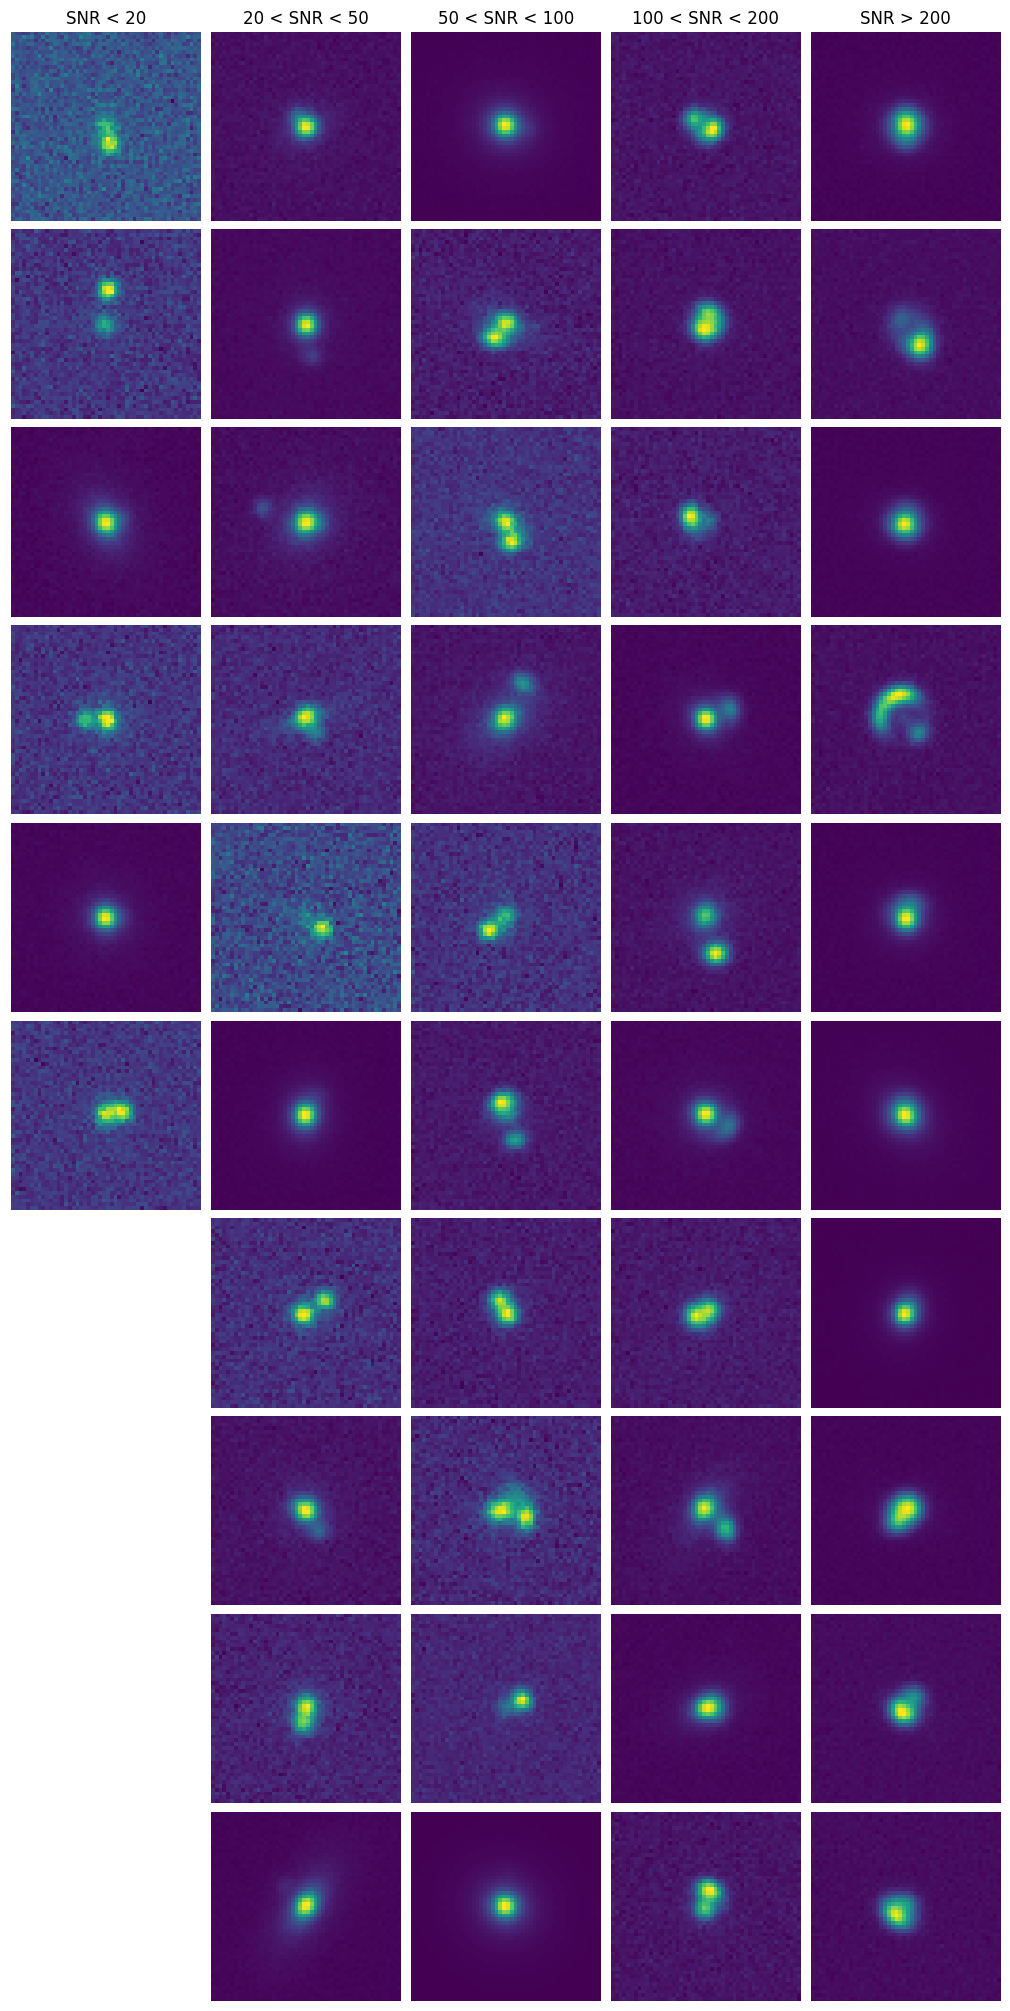

In [5]:
# Define SNR bins: (lower_bound, upper_bound, title)
snr_bins = [
    (None, 20, "SNR < 20"),
    (20, 50, "20 < SNR < 50"),
    (50, 100, "50 < SNR < 100"),
    (100, 200, "100 < SNR < 200"),
    (200, None, "SNR > 200"),
]
buckets = {i: [] for i in range(len(snr_bins))}

for gg_lens in gg_lens_population:
    theta_e = gg_lens.einstein_radius[0]
    snr = gg_lens.snr(
        band="g",
        fov_arcsec=np.max([theta_e * 4, 1]),  # 4 times Einstein radius, or at least 1"
        observatory="LSST",
        snr_per_pixel_threshold=1,
    )

    image = simulate_image(
        lens_class=gg_lens,
        band="g",
        observatory="LSST",
        add_noise=True,
        num_pix=50,
        with_source=True,
        with_deflector=True,
        with_point_source=True,
    )

    # Assign image to appropriate bucket
    for idx, (low, high, _) in enumerate(snr_bins):
        if snr is None and low is None:
            buckets[idx].append(image)
            break
        elif snr is not None:
            if (low is None or snr >= low) and (high is None or snr < high):
                buckets[idx].append(image)
                break

# Plot results
n_rows = 10
_, ax = plt.subplots(n_rows, len(snr_bins), figsize=(10, 20), constrained_layout=True)

for col, (_, _, title) in enumerate(snr_bins):
    ax[0, col].set_title(title)
    for row in range(n_rows):
        ax[row, col].axis("off")
        if row < len(buckets[col]):
            ax[row, col].imshow(buckets[col][row], origin="lower", cmap="viridis")

plt.show()